Running a linear regression on fluxes above a certain threshold, to see if this decreases relative error.

In [204]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [205]:
dataDIR = 'short'
DS = xr.open_dataset(dataDIR)

In [206]:
#Temperature:
T = (DS.T.values + DS.T0) * ((DS.P.values + DS.PB.values)/DS.P0)**(DS.R_D/DS.CP)

In [207]:
T.shape #days, height, latitude, longtitude

(240, 52, 36, 72)

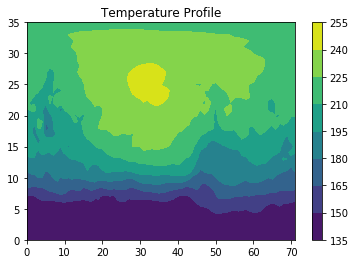

In [208]:
example_data = T[50,5,:, :]
plt.contourf(example_data)
plt.colorbar()
plt.title("Temperature Profile")
plt.show()

In [209]:
albedo = DS.ALBEDO.values

In [210]:
albedo.shape #days, latitude, longtitude

(240, 36, 72)

In [211]:
st = DS.TSK.values

In [212]:
st.shape

(240, 36, 72)

In [213]:
d_c = DS.TAU_OD.values

In [214]:
d_c.shape 

(240, 52, 36, 72)

In [215]:
tsf = DS.TOASW.values #top solar flux

In [216]:
tsf.shape

(240, 36, 72)

In [217]:
albedo = DS.ALBEDO.values

In [218]:
bsf = DS.GSW.values #bottom solar flux, ouput

In [219]:
bsf2 = bsf/(1-albedo)

In [220]:
bsf.shape

(240, 36, 72)

Let's combine the data together for one time snapshot, full latitude and longitude:

In [221]:
e_t = [] #equator input and output
#input:
for i in range(36):
    for j in range(72):
        input_array = list(T[3,:,i,j]) #start with temp profile
        input_array+=list(d_c[3,:,i,j]) #add dust profile
        input_array.append(st[3,i,j])#add surface temp
        input_array.append(tsf[3,i,j]) #add top solar flux, without the albedo factor
        input_array.append(bsf2[3,i,j])            
        e_t.append(input_array) #appends input to input array

In [222]:
e_t = np.array(e_t)
e_t.shape

(2592, 107)

In [223]:
e_d = pd.DataFrame(e_t) 

In [225]:
e_rems = e_d[e_d.iloc[:,105] > 20] #small values, less than 10% of the average

In [226]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(e_rems, test_size=0.2, random_state=42)

In [227]:
train_set.shape

(997, 107)

In [228]:
test_set.shape

(250, 107)

In [229]:
train_in = train_set.iloc[:,:106] #training input
train_out = train_set.iloc[:,106] #training output
test_in = test_set.iloc[:,:106] #training input
test_out = test_set.iloc[:,106] #training output
total_in = e_rems.iloc[:,:106] #total input
total_out = e_rems.iloc[:,106] #total output


In [230]:
#this provides the location of each point according to the date and latitude
indices = np.array(train_in.index)
all_indices = np.array(total_in.index)

Let's try linear regression

In [231]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_in, train_out)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [232]:
from sklearn.metrics import mean_squared_error

train_pred = lin_reg.predict(train_in) #prediction
lin_mse = mean_squared_error(train_out, train_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

1.6136206

In [233]:
total_pred_out = lin_reg.predict(total_in)

In [234]:
train_out = np.array(train_out)
pred_contour = np.full((36, 72), np.nan)
lat_list = []
long_list = []
for i in range(len(indices)):
    lat_point = indices[i]//72
    long_point = indices[i]%72
    lat_list.append(lat_point)
    long_list.append(long_point)
    pred_contour[lat_point][long_point] = train_pred[i]
lat_list = np.array(lat_list)
long_list = np.array(long_list)

out_contour = np.full((36, 72), np.nan)
for i in range(len(indices)):
    lat_point = indices[i]//72
    long_point = indices[i]%72
    out_contour[lat_point][long_point] = train_out[i]  

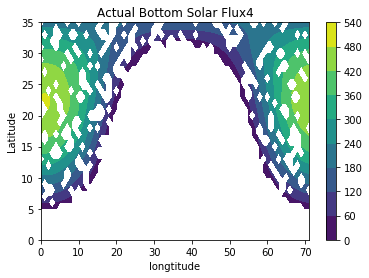

<Figure size 432x288 with 0 Axes>

In [235]:
plt.contourf(out_contour)
plt.colorbar()
plt.title("Actual Bottom Solar Flux4")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()
plt.savefig("Actual")

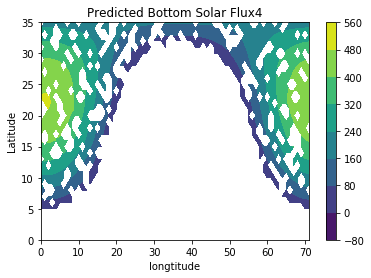

<Figure size 432x288 with 0 Axes>

In [236]:
plt.contourf(pred_contour)
plt.colorbar()
plt.title("Predicted Bottom Solar Flux4")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()
plt.savefig("Predicted")

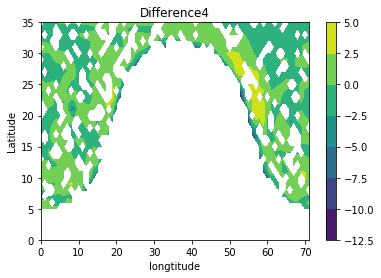

In [237]:
plt.contourf(pred_contour - out_contour)
plt.colorbar()
plt.title("Difference4")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()

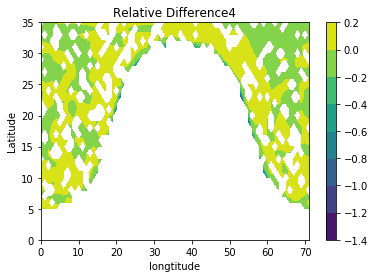

In [238]:
plt.contourf((pred_contour - out_contour)/out_contour)
plt.colorbar()
plt.title("Relative Difference4")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()

In [239]:
total_out = np.array(total_out)
full_out_contour = np.full((36, 72), np.nan)
for i in range(len(np.array(total_in.index))):
    lat_point = all_indices[i]//72
    long_point = all_indices[i]%72
    full_out_contour[lat_point][long_point] = total_out[i]

full_pred_contour = np.full((36, 72), np.nan)
for i in range(len(np.array(total_in.index))):
    lat_point = all_indices[i]//72
    long_point = all_indices[i]%72
    full_pred_contour[lat_point][long_point] = total_pred_out[i]  

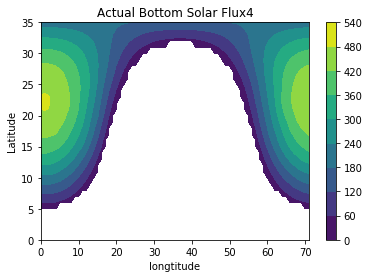

<Figure size 432x288 with 0 Axes>

In [240]:
plt.contourf(full_out_contour)
plt.colorbar()
plt.title("Actual Bottom Solar Flux4")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()
plt.savefig("Actual")

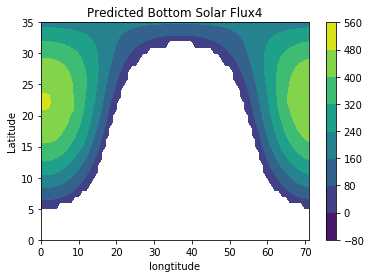

<Figure size 432x288 with 0 Axes>

In [241]:
plt.contourf(full_pred_contour)
plt.colorbar()
plt.title("Predicted Bottom Solar Flux4")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()
plt.savefig("Predicted")

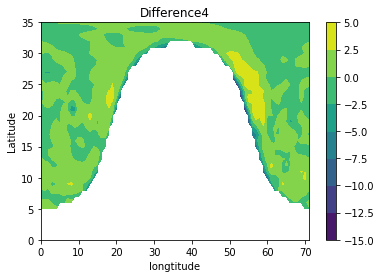

In [242]:
plt.contourf(full_pred_contour - full_out_contour)
plt.colorbar()
plt.title("Difference4")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()

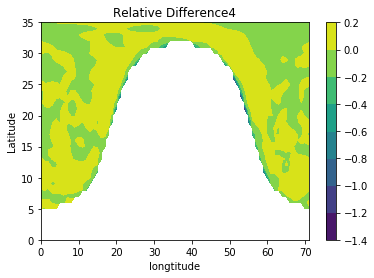

In [243]:
plt.contourf((full_pred_contour - full_out_contour)/full_out_contour)
plt.colorbar()
plt.title("Relative Difference4")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()